In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
from scipy.integrate import odeint

## Transfer Function

A simple one pole RC filter has the following transfer function

$$
G(s) = \frac{1}{1+\tau\cdot{s}}
$$

And the following differential equation

$$
V_{out}(t) = V_{in}(t)-RC \frac{dV_{out}}{dt}
$$

In [131]:
tau = 4*10**(-5) # Time constant
F = 5000 #Hz
hz2rad = lambda f: 2*math.pi*f
rad2hz = lambda omega: omega/(2*math.pi)

def Gain(f):
    omega = hz2rad(f)
    k = 1 + tau**2*omega**2
    r = tau*omega
    
    return math.sqrt((1/k)**2 + (r/k)**2)

def Phase(f):
    r = tau*hz2rad(f)
    return -2*math.pi*math.atan(r)

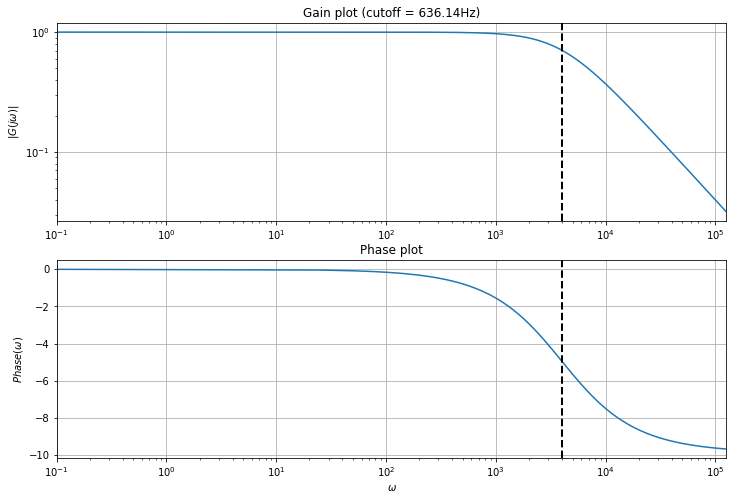

In [132]:
w = np.linspace(0.1,hz2rad(20000),5000) # frequencies
GainV = np.vectorize(Gain)
PhaseV = np.vectorize(Phase)
G = GainV(w)
P = PhaseV(w)

gainSeries = pd.Series(G) 
cutoffIndex = gainSeries[gainSeries < 1/np.sqrt(2)].index[0]
cutoffFreq = w[cutoffIndex]

################################ plot

fig,axs = plt.subplots(2,1)

axs[0].plot(w,G)
axs[0].axvline(x = cutoffFreq, ls = '--', c='black', lw=2)
axs[0].set_title('Gain plot (cutoff = {:.2f}Hz)'.format(rad2hz(cutoffFreq)))
axs[0].set_ylabel('$|G(j\omega)|$')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlim(0.1, hz2rad(20000))

axs[1].plot(w,P)
axs[1].axvline(x = cutoffFreq, ls = '--', c='black', lw=2)
axs[1].set_xscale('log')
axs[1].set_xlim(0.1, hz2rad(20000))


axs[1].set_title('Phase plot')
axs[1].set_ylabel('$Phase(\omega)$')
axs[1].set_xlabel('$\omega$')
axs[1].grid()

axs[0].grid()
fig.set_size_inches(12,8)

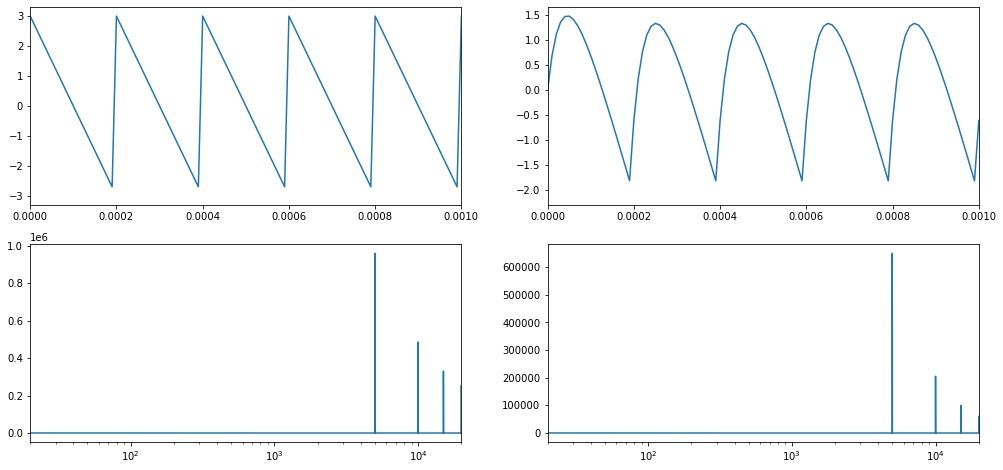

In [137]:
# sinal de entrada

def SawWave(x,f):
    amp = 3
    T = 1/f
    
    dydx = (-2*amp)/T 
    return (x%T)*dydx + amp

t = np.linspace(0,10,10**6)
x = [SawWave(i,F) for i in t]

# exit signal
# calculated using euler method for differential equations

dt = t[1]-t[0]
y = [0]

for i in range(1, len(t)):
    dydt = (x[i] - y[i-1]) / tau
    y.append(y[i-1] + dt * dydt)
    
fft_x = np.fft.fft(x)
fft_y = np.fft.fft(y)
freq = np.fft.fftfreq(len(t),dt)

fig, axs = plt.subplots(2,2)
axs[0,0].plot(t,x)
axs[0,0].set_xlim(0,5/F)

axs[0,1].plot(t,y)
axs[0,1].set_xlim(0,5/F)

axs[1,0].plot(freq[:len(freq)//2], np.abs(fft_x[:len(freq)//2]))
axs[1,1].plot(freq[:len(freq)//2], np.abs(fft_y[:len(freq)//2]))
axs[1,0].set_xscale('log')
axs[1,0].set_xlim(20,20000)
# axs[1,0].set_ylim(1,500000)
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(20,20000)
# axs[1,1].set_ylim(1,500000)

fig.set_size_inches(17,8)


(0.0, 0.00625)

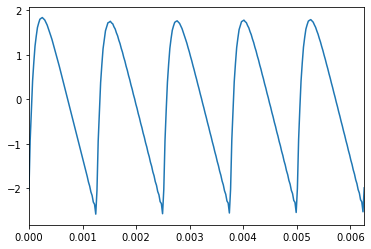

In [99]:
def transfer_func(freq, tau):
    w = 2 * np.pi * freq  # FrequÃªncia angular
    return 1 / (1 + 1j * w * tau)

H_w = transfer_func(freq, tau)
Y_f = fft_x * H_w

y_fourier = np.fft.ifft(Y_f)
plt.plot(t,np.real(y_fourier))
plt.xlim(0,5/F)

(0.0, 0.001)

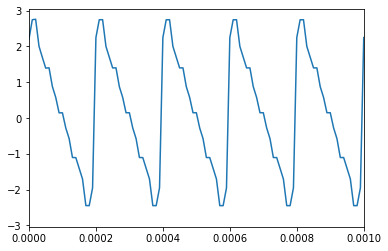

In [138]:
# filtering the signal by changing its fourier components

for i in range(len(freq[:len(freq)//2])):
    if(freq[i] > 20000):
        fft_x[i] = 0

newX = np.fft.ifft(fft_x)

plt.plot(t,np.real(newX))
plt.xlim(0,5/F)